In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

In [3]:
from utils import gen_covariance, sparsify_beta
from scipy.special import binom
import itertools

In [4]:
# Eq 14 in Wainwright
def wgfunction(c1, p, k, beta_min, sigma, rho):
    return (c1 + 2048) * max(np.log(binom(p -k, k)), np.log(p - k)/(rho * beta_min**2/sigma**2))

In [5]:
def sgfunction(delta1, delta2, p, k, beta, sigma, rho):
    gamma0 = np.log(1/np.unique(beta[np.nonzero(beta)]))
    
    # Sort beta
    beta = np.sort(beta)
    
    # Iterate over all possible subset dimensions
    nl = np.zeros(k - 1)    
    for l in range(1, k):
        # Find the magnitude of the first l components
        beta_min = np.linalg.norm(beta[:l])**2
        alpha = beta_min * rho/sigma**2
        numerator = np.log(binom(p - k, l)) + 2 * np.log(k/delta1 * binom(k, l)) + gamma0
        denominator = 1/2 * (1 + alpha**2) * (1 - delta2)
        nl[l - 1] = numerator/denominator
    return np.max(nl)

In [6]:
def serror_fn(delta1, delta2, p, k, beta, sigma, rho):
    
    n = sgfunction(delta1, delta2, p, k, beta, sigma, rho)
    beta = np.sort(beta)
    perror = 0
    for l in range(1, k):
        bb = beta[beta != 0]
        beta_min = np.linalg.norm(bb[:l])**2
        alpha = beta_min * rho/sigma**2
        error_exponent = -1/16 * (delta2 * n) * np.log(1 + alpha**2)**2\
        /(alpha * (1 + alpha)/(1 + alpha**2) * (8*(1 + alpha)/(1 + alpha**2) + delta2/2 * np.log(1 + alpha**2)))

        perror += binom(k, l) * np.exp(error_exponent)
        perror += 2 * delta1
    return n, perror

In [7]:
def bound_eigenvalue(matrix, k):
    
    # Sort each row
    ordering = np.argsort(matrix, axis = 1)

    # Change to descending order
    ordering = np.fliplr(ordering)
    
    matrix = matrix[ordering]
    # Find the diagonal and move it first
    
    diagonal_locs = np.array([np.where(ordering[i, :] == i)[0][0] 
                              for i in range(ordering.shape[0])])
    for (row, column) in zip(range(ordering.shape[0]), diagonal_locs):
        matrix[row][:column+1] = np.roll(matrix[row][:column+1], 1)
            
    # Sum the first k elements
    row_sums = np.sum(matrix[:, 0:k], axis = 1)

    # Evaluate all Bauer Cassini ovals
    pairs = set(list(itertools.combinations(np.arange(p), 2)))
    ovals = np.array([np.product(row_sums[idx]) for idx in pairs])
    
    # Take the max. This is a bound for any conceivable eigenvalue
    eig_bound = np.max(ovals)
    
    return eig_bound

### Wainwright calculation

In [ ]:
# Wainwright calculation
p = 500
k = np.linspace(10, 200, 10, dtype=int)
sigma = np.linspace(0.1, 5, 25)
L = np.linspace(1, 50, 25)
c1 = 1
# Keep beta_min fixed.
beta_min = 5
beta = beta_min * np.ones(p)

# Store the number of samples and the corresponding errors
nw = np.zeros((k.size, sigma.size, L.size, 3, 5))
werrors = np.zeros((k.size, sigma.size, L.size, 3, 5))

for i1, k_ in enumerate(k):
    print(i1) 
    t0 = time.time()        
    for i2, ss in enumerate(sigma):
        for i3, l in enumerate(L):
            # Sparsify beta
            bb = sparsify_beta(beta, p, k_/p, seed = 1234)
            # Generate the appropriate covariance
            Sigma = gen_covariance(p, 1, p, l, 1)
            
            # Bound the minimum shcur complement eigenvalue
            inverse_eig_bound = bound_eigenvalue(np.linalg.inv(Sigma), k_)
            eig_bound = 1/inverse_eig_bound
            n_ = wgfunction(c1, p, k_, beta_min, np.sqrt(ss), eig_bound)
            error_ = np.exp(-c1 * (n_ - k_))                
            nw[i1, i2, i3] = n_
            werrors[i1, i2, i3] = error_
    print('%f s' % (time.time() - t0))


0
535.273914 s
1
539.561484 s
2
542.402190 s
3
542.100997 s
4
549.844115 s
5
562.362405 s
6
567.371670 s
7


In [21]:
# Scarlett calculation...

p = 500
k = np.linspace(10, 200, 2, dtype=int)
sigma = np.linspace(0.1, 5, 2)
L = np.linspace(1, 50, 2)

# Keep beta_min fixed.
beta_min = 5
beta = beta_min * np.ones(p)

# Store the number of samples and the corresponding errors
ns = np.zeros((k.size, sigma.size, L.size, 3, 5))
serrors = np.zeros((k.size, sigma.size, L.size, 3, 5))

for i1, k_ in enumerate(k):
    for i2, ss in enumerate(sigma):
        for i3, l in enumerate(L):
            print((i1, i2, i3)) 
            t0 = time.time()
            # Sparsify beta
            bb = sparsify_beta(beta, p, k_/p, seed = 1234)
            # Generate the appropriate covariance
            Sigma = gen_covariance(p, 1, p, l, 1)
            
            # Bound the minimum shcur complement eigenvalue
            inverse_eig_bound = bound_eigenvalue(np.linalg.inv(Sigma), k_)
            eig_bound = 1/inverse_eig_bound
                    
            # Calculate the n threshold over a grid of delta1 and delta2:
            delta1 = np.array([1/p, 1/(p**2), np.exp(-p)])
            delta2 = np.linspace(0.001, 1, 5)
            for didx1, d1 in enumerate(delta1): 
                for didx2, d2 in enumerate(delta2):
                    n_, error_ = serror_fn(d1, d2, p, k_, bb, np.sqrt(ss), eig_bound)            
                    ns[i1, i2, i3, didx1, didx2] = n_
                    serrors[i1, i2, i3, didx1, didx2] = error_
            print('%f s' % (time.time() - t0))
#             ns[i1, i2, i3] = ns_
#             serrors[i1, i2, i3] = serror_

(0, 0, 0)


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


1.410229 s
(0, 0, 1)
1.442146 s
(0, 1, 0)
1.195804 s
(0, 1, 1)
1.397266 s
(1, 0, 0)
1.775258 s
(1, 0, 1)
1.368847 s
(1, 1, 0)
1.392279 s
(1, 1, 1)
1.548924 s


In [23]:
ns

array([[[[[  125.93401757,   167.91202342,   251.86803514,
             503.73607027,            inf],
          [  150.81733328,   201.0897777 ,   301.63466655,
             603.26933311,            inf],
          [ 2103.05270386,  2804.07027181,  4206.10540772,
            8412.21081544,            inf]],

         [[  125.93401757,   167.91202342,   251.86803514,
             503.73607027,            inf],
          [  150.81733328,   201.0897777 ,   301.63466655,
             603.26933311,            inf],
          [ 2103.05270386,  2804.07027181,  4206.10540772,
            8412.21081544,            inf]]],


        [[[  125.93401757,   167.91202342,   251.86803514,
             503.73607027,            inf],
          [  150.81733328,   201.0897777 ,   301.63466655,
             603.26933311,            inf],
          [ 2103.05270386,  2804.07027181,  4206.10540772,
            8412.21081544,            inf]],

         [[  125.93401757,   167.91202342,   251.86803514,
      

In [24]:
serrors

array([[[[[3.60001281e-002, 3.60000000e-002, 3.60000000e-002,
           3.60000000e-002, 3.60000000e-002],
          [7.20035317e-005, 7.20000000e-005, 7.20000000e-005,
           7.20000000e-005, 7.20000000e-005],
          [1.57640732e-131, 1.28242375e-216, 1.28242375e-216,
           1.28242375e-216, 1.28242375e-216]],

         [[4.28565482e+002, 3.62177764e-002, 3.60000000e-002,
           3.60000000e-002, 3.60000000e-002],
          [3.69447437e+002, 9.81124620e-005, 7.20000001e-005,
           7.20000000e-005, 7.20000000e-005],
          [7.77983936e+000, 1.40107060e-077, 3.40504985e-197,
           1.28242375e-216, 1.28242375e-216]]],


        [[[5.78317443e+002, 6.27326153e-002, 3.60013458e-002,
           3.60000000e-002, 3.60000000e-002],
          [5.22259472e+002, 8.36382720e-003, 7.20590635e-005,
           7.20000000e-005, 7.20000000e-005],
          [1.84644620e+001, 1.07775175e-042, 1.80395177e-114,
           1.28242375e-216, 1.28242375e-216]],

         [[1.0219499

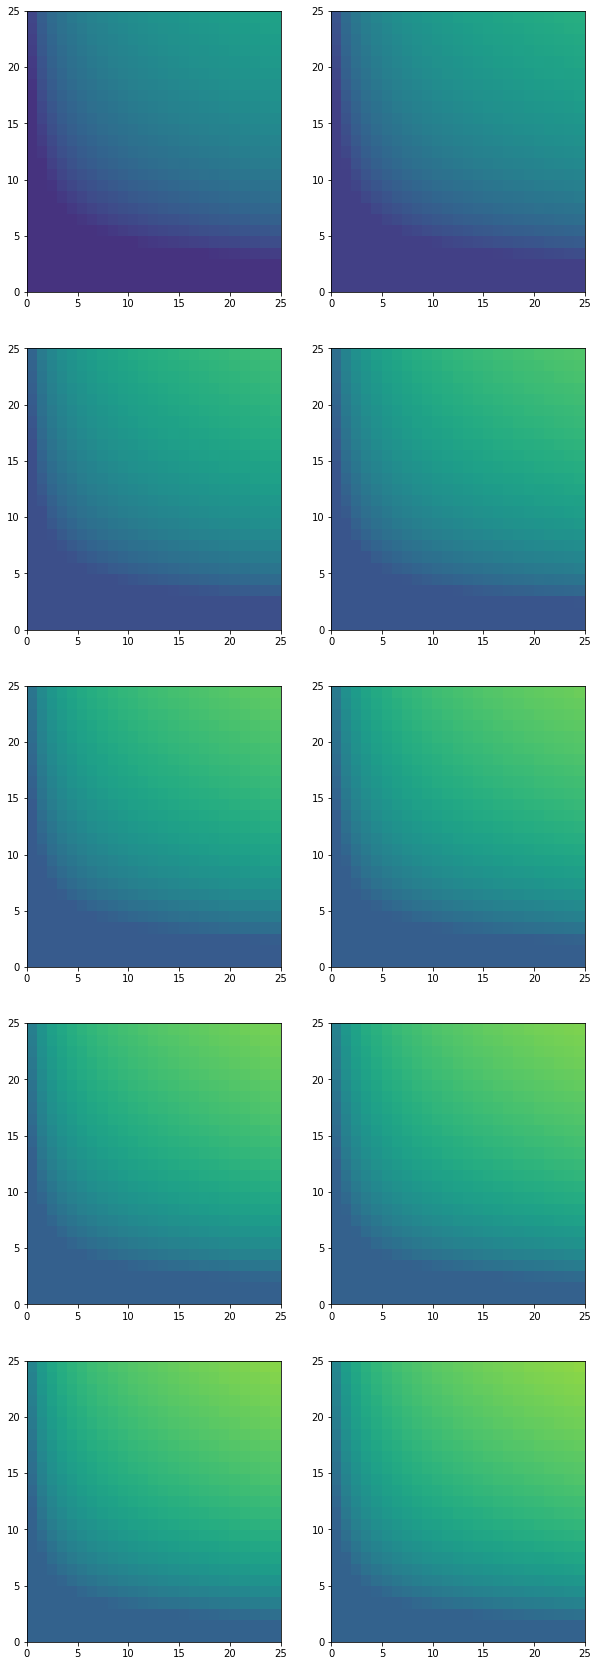

In [44]:
# For a few different sparsities, plot colormaps of n for different values of sigma and L:
fig, ax = plt.subplots(5, 2, figsize = (10, 30))

sparsities = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

for i in range(10):
    
    a = ax[np.unravel_index(i, (5, 2))]
    
    a.pcolormesh(np.log(ng[sparsities[i], :, :]), vmin = 10,  vmax = 20)

In [ ]:
# Now let's do the same non-asymptotic characterization for the more involved method

In [27]:
from scipy.sparse.linalg import eigsh

In [28]:
import itertools
import time

In [41]:
# Let's evaluate how good the Cassini bounds are for 5x5 subblocks of 20x20 matrices

n_matrices = 25

lambda_max = np.zeros(n_matrices)
lambda_max_est = np.zeros(n_matrices)

p = 20
k = 5

for i in range(n_matrices):
    t0 = time.time()
    # Randomly generate a matrix
    matrix = np.random.rand(p, p)
    
    # Set the diagonal to be all 1. This should keep things non-singular with high probability
    np.fill_diagonal(matrix, 1)
        
    # Iterate over all possible 5x5 subblocks and get the corresponding minimum and maximum eigenvalues of the
    # subblocks.
    subsets = set(list(itertools.combinations(np.arange(p), k)))
    
    lmax = np.zeros(len(subsets))
    
    for j, ss in enumerate(subsets):
        
        # Calculate the largest and smallest eigenvalues of the sublock
        subblock = matrix[np.ix_(ss, ss)]
        lmax[j] = eigsh(subblock, k = 1, return_eigenvectors=False, which='LM')
        
    lambda_max[i] = np.max(lmax)
    
    # What are the corresponding estimates from Gershorgin?
    lambda_max_est[i] = bound_eigenvalue(np.linalg.inv(matrix), k)
    
    print('%d, time: %f' % (i, time.time() - t0))

0, time: 2.943030
1, time: 2.953082
2, time: 3.543841
3, time: 2.949167
4, time: 2.972614
5, time: 3.078462
6, time: 2.922796
7, time: 3.179802
8, time: 3.158143
9, time: 2.850922
10, time: 2.997545
11, time: 2.903805
12, time: 3.389719
13, time: 3.141805
14, time: 3.411254
15, time: 2.951893
16, time: 3.043934
17, time: 5.991881
18, time: 4.350265
19, time: 5.469931
20, time: 5.607200
21, time: 4.959137
22, time: 4.722726
23, time: 5.067357
24, time: 4.374766


(array([5., 4., 1., 2., 4., 1., 3., 2., 1., 2.]),
 array([4.04181512, 4.07436625, 4.10691738, 4.13946851, 4.17201965,
        4.20457078, 4.23712191, 4.26967304, 4.30222417, 4.33477531,
        4.36732644]),
 <a list of 10 Patch objects>)

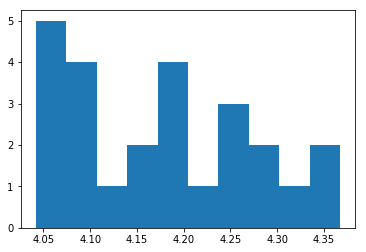

In [42]:
plt.hist(lambda_max)

(array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.35749435e+00,  1.59866072e+02,  3.21089639e+02,  4.82313206e+02,
         6.43536773e+02,  8.04760340e+02,  9.65983907e+02,  1.12720747e+03,
         1.28843104e+03,  1.44965461e+03,  1.61087817e+03]),
 <a list of 10 Patch objects>)

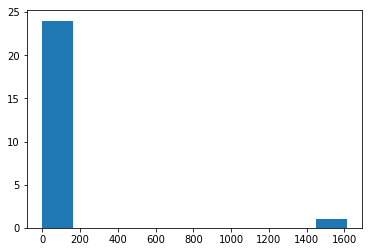

In [44]:
plt.hist(lambda_max_est - lambda_max)